# Прогноз продаж в интернет-магазине

Нужно выявить определяющие успешность игры и закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании, для интернет-магазине «Стримчик», кторый продаёт по всему миру компьютерные игры. 

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 


Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и нужно спланировать кампанию на 2017-й. Нужно отработать принцип работы с данными. 

В наборе данных попадается аббревиатура ESRB, оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Загрузка данных,  изучение общей информации

In [1]:
#загрузим нужыне в работе билблиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
from scipy import stats as st
import seaborn as sns

#кол-во колонок на просмотре
pd.set_option('display.max_columns', 25)
#большие числа показывать без плавующей точки
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
# загружаем данные по всем таблицам
# серверный yandex-путь
try:
    df = pd.read_csv('/datasets/games.csv', sep=',')

except:
    from google.colab import drive
    df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/csv/games.csv')   
# colab-облачный

In [3]:
display(df.head(10))

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN
5,Tetris,GB,1989.00,Puzzle,23.20,2.26,4.22,0.58,nan,NaN,NaN
6,New Super Mario Bros.,DS,2006.00,Platform,11.28,9.14,6.50,2.88,89.00,8.5,E
7,Wii Play,Wii,2006.00,Misc,13.96,9.18,2.93,2.84,58.00,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.00,Platform,14.44,6.94,4.70,2.24,87.00,8.4,E
9,Duck Hunt,NES,1984.00,Shooter,26.93,0.63,0.28,0.47,nan,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
#проверим кол-во пропусков по колонкам и их процент относительно всех данных
numb_of_null = pd.DataFrame(columns=['names'], data=df.columns)
numb_of_null['кол-во пропущенных значений'] = df.isnull().sum().values
numb_of_null['процент пропусков ко всем данным'] = 100*df.isnull().sum().values/df.shape[0]
numb_of_null 

,names,кол-во пропущенных значений,процент пропусков ко всем данным
0,Name,2,0.01
1,Platform,0,0.00
2,Year_of_Release,269,1.61
3,Genre,2,0.01
4,NA_sales,0,0.00
5,EU_sales,0,0.00
6,JP_sales,0,0.00
7,Other_sales,0,0.00
8,Critic_Score,8578,51.32
9,User_Score,6701,40.09


In [6]:
#Также проверим дубликаты
print(df.duplicated().sum())

0


Мы видим таблицу с историческими данными из открытых источников доступны о продажах игр.

Name — название игры \
Platform — платформа \
Year_of_Release — год выпуска \
Genre — жанр игры \
NA_sales — продажи в Северной Америке (миллионы проданных копий) \
EU_sales — продажи в Европе (миллионы проданных копий) \
JP_sales — продажи в Японии (миллионы проданных копий) \
Other_sales — продажи в других странах (миллионы проданных копий) \
Critic_Score — оценка критиков (максимум 100) \
User_Score — оценка пользователей (максимум 10) \
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

В данных есть проблемы с типами, проблемы с верхними регистрами, есть пропуски. Дубликатов нет.

Скорее пропуски связаны с нехваткой данных из-за большого периода выпуска игр, возможно рейтинги не столь давно ведут. Либо вообще часть игр не имеет больших продаж и ее даже не оценивали.

## Подготовка данных

### Заменим названия столбцов, проверим чило пропущенных значений 

In [7]:
#Приведем колонки к нижнему регистру
df.columns = df.columns.str.lower()

In [8]:
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.00,Action,0.00,0.00,0.01,0.00,nan,NaN,NaN
16711,LMA Manager 2007,X360,2006.00,Sports,0.00,0.01,0.00,0.00,nan,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.00,Adventure,0.00,0.00,0.01,0.00,nan,NaN,NaN
16713,Spirits & Spells,GBA,2003.00,Platform,0.01,0.00,0.00,0.00,nan,NaN,NaN


In [9]:
#удалим пропуски по колонкам Name и Genre так как их кол-во равно 2 шт что очень мало отвсех данных 
df.dropna(subset=['name'], inplace=True)

### Преобразуем данные в нужные типы

User_score со значениями tbd заменим на NaN, так как выкинуть значения не можем просто, но и если заменим на средние будет не очень логично.
Так же поменяем формат на float64


In [10]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['user_score'] = df['user_score'].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


### Обработаем пропуски 

Заменим в столбце с рейтингом категориальные данные на количественные с возрастом категории , которые можно будет сравнивать, а пропуски заменим на значения 'no_data' и поменяем формат на float

M - 15+ \
E - 6+ (everyone) \
T - 13+ \
E10+ - 10+\
K-A - 10+ \
EC - 3+ \
AO - 18+ \
RP - pending

In [11]:
df_a = (df
    .groupby('rating')
    .agg({'na_sales':['sum']})
    .sort_values(by=('na_sales', 'sum'), ascending=False)
)
df_a

,na_sales
,sum
rating,
E,1292.99
T,759.75
M,748.48
E10+,353.32
K-A,2.56
EC,1.53
AO,1.26
RP,0.00


In [12]:
df['rating'] = df['rating'].replace('M', 15)
df['rating'] = df['rating'].replace('E', 6)
df['rating'] = df['rating'].replace('T', 13)
df['rating'] = df['rating'].replace('E10+', 10)
df['rating'] = df['rating'].replace('K-A', 10)
df['rating'] = df['rating'].replace('EC', 3)
df['rating'] = df['rating'].replace('AO', 3)
df['rating'] = df['rating'].replace('RP', np.nan)
df['rating'].value_counts()

6.00     3990
13.00    2961
15.00    1563
10.00    1423
3.00        9
Name: rating, dtype: int64

In [13]:
df['rating'] = df['rating'].fillna('no_data')


In [14]:
df.isna().mean()

name              0.00
platform          0.00
year_of_release   0.02
genre             0.00
na_sales          0.00
eu_sales          0.00
jp_sales          0.00
other_sales       0.00
critic_score      0.51
user_score        0.55
rating            0.00
dtype: float64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             16713 non-null object
dtypes: float64(7), object(4)
memory usage: 2.2+ MB


Мы обработали данные - убрали проспуки и привели их к общему формату, убрали не логичные значения.

### Посчитаем суммарные продажи во всех регионах

In [16]:
# посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец

df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

Вывод

В рейтинге не менял на int, так как есть вероятность получить десятичное число в данных колонках и округление будет не разумно, тем более вижу более разумным их сделать одним форматом  float64 все. Полагаем наличие пропусков обосновывается не ошибкой, а отсутствием информации и заменять их на средние или т.п. не вижу смысла. Так же делали дополнительный столбец с суммой проданных копий.

## Исследовательский анализ данных

###  Сколько игр выпускалось в разные годы



Text(0.5, 0, 'Год выпуска')

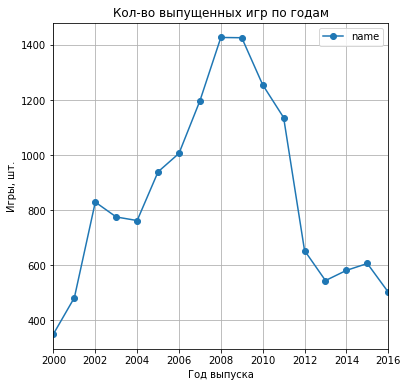

In [17]:
count_by_year = df.query('year_of_release >= 2000').groupby('year_of_release')['name'].count()
count_by_year.plot(legend=True, style='o-', grid=True, figsize=(6, 6), title='Кол-во выпущенных игр по годам')
ax = plt.gca()
ax.set_ylabel('Игры, шт.')
ax.set_xlabel('Год выпуска')

Мы видим реский рост продаж на игры с 1996 и спад с 2008 года. Основной период с 2000 по 2015. Большой части игр нету в 2016 году, его можно не трогать. Рассмотрим интервал с 2009 года по 2015, когда у нас наиболее актуальные данные.

Полагаю причина спада - перестроение и изменение рынка в посткризисное время после 2008.

Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Определим какой характерный срок появляются новые и исчезают старые платформы?

###  Как менялись продажи по платформам


In [18]:
top_platforms = (df
    .query('2000 <= year_of_release <= 2015')
    .groupby('platform')
    .agg({'total_sales':['sum']})
    .sort_values(by=('total_sales', 'sum'), ascending=False)
    .head(10)
)
top_platforms

,total_sales
,sum
platform,
PS2,1233.56
X360,959.72
PS3,927.74
Wii,891.00
DS,802.76
GBA,312.88
PSP,289.53
XB,251.57


In [19]:
platform = (df
    .query('platform in @top_platforms.index and 2000 <= year_of_release <= 2015')
    .groupby(['platform','year_of_release'])
    .agg({'total_sales':['sum']})
) 
platform.head(50)

total_sales
                                 sum
platform year_of_release            
3DS      2011.00               63.20
         2012.00               51.36
         2013.00               56.57
         2014.00               43.76
         2015.00               27.78
DS       2004.00               17.27
         2005.00              130.14
         2006.00              119.81
         2007.00              146.94
         2008.00              145.31
         2009.00              119.54
         2010.00               85.02
         2011.00               26.18
         2012.00               11.01
         2013.00                1.54
GBA      2000.00                0.07
         2001.00               61.53
         2002.00               74.16
         2003.00               56.67
         2004.00               77.91
         2005.00               33.86
         2006.00                5.28
         2007.00                3.40
PS2      2000.00               39.17
         2001.00              166.43
         2002.00              205.38
         2003.00              184.31
         2004.00              211.81
         2005.00              160.66
         2006.00              103.42
         2007.00               75.99
         2008.00               53.90
         2009.00               26.40
         2010.00                5.64
         2011.00                0.45
PS3      2006.00               20.96
         2007.00               73.19
         2008.00              118.52
         2009.00              130.93
         2010.00              142.17
         2011.00              156.78
         2012.00              107.36
         2013.00              113.25
         2014.00               47.76
         2015.00               16.82
PS4      2013.00               25.99
         2014.00              100.00
         2015.00              118.90
PSP      2004.00                7.06
         2005.00               43.84

In [20]:
#удалим мультииндекс с годами и посчитаем количество лет жизни платформы за последние 15 лет без выбросов

platform.droplevel(level=1).index.value_counts()

PSP     12
PS2     12
X360    11
PS3     10
DS      10
Wii     10
XB       9
GBA      8
3DS      5
PS4      3
Name: platform, dtype: int64

In [21]:
platform.droplevel(level=1).index.value_counts().mean()

9.0

Мы видим что средний срок жизни платформы 9 лет по данным с 2000 по 2015 год. Но самые актуальные для нас данные в посткризисное время после 2008.

Теперь посмотрим данные по топовым платформам именно за интервал с 2009 - 2015

In [22]:
top10_platform = (df
    .query('2009 <= year_of_release <= 2015')
    .groupby('platform')
    .agg({'total_sales':['sum']})
    .sort_values(by=('total_sales', 'sum'), ascending=False)
    .head(10)
)
top10_platform

,total_sales
,sum
platform,
PS3,715.07
X360,669.18
Wii,429.76
PS4,244.89
DS,243.29
3DS,242.67
PC,133.62
XOne,133.17


###  Какие платформы лидируют по продажам


In [23]:
(df
    .query('2009 <= year_of_release <= 2015 and platform in @top10_platform.index')
    .pivot_table(index='platform', columns='year_of_release', values='total_sales',aggfunc='sum')
)

year_of_release,2009.00,2010.00,2011.00,2012.00,2013.00,2014.00,2015.00
platform,,,,,,,
3DS,nan,nan,63.20,51.36,56.57,43.76,27.78
DS,119.54,85.02,26.18,11.01,1.54,nan,nan
PC,16.91,24.28,35.03,23.22,12.38,13.28,8.52
PS3,130.93,142.17,156.78,107.36,113.25,47.76,16.82
PS4,nan,nan,nan,nan,25.99,100.00,118.90
PSP,37.78,35.04,17.82,7.69,3.14,0.24,0.12
Wii,206.97,127.95,59.65,21.71,8.59,3.75,1.14
WiiU,nan,nan,nan,17.56,21.65,22.03,16.35
X360,120.29,170.03,143.84,99.74,88.58,34.74,11.96


In [24]:
#Сохраним отдельный df с нашей выборкой по годам и платформ с топ 10 по оборотам

df_top10_2009 = (df
    .query('2009 <= year_of_release <= 2015 and platform in @top10_platform.index')
    .copy()
) 
df_top10_2009.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8.00,6.00,32.77
8,New Super Mario Bros. Wii,Wii,2009.00,Platform,14.44,6.94,4.70,2.24,87.00,8.40,6.00,28.32
14,Kinect Adventures!,X360,2010.00,Misc,15.00,4.89,0.24,1.69,61.00,6.30,6.00,21.82
15,Wii Fit Plus,Wii,2009.00,Sports,9.01,8.49,2.53,1.77,80.00,7.40,6.00,21.80
16,Grand Theft Auto V,PS3,2013.00,Action,7.02,9.09,0.98,3.96,97.00,8.20,15.00,21.05
23,Grand Theft Auto V,X360,2013.00,Action,9.66,5.14,0.06,1.41,97.00,8.10,15.00,16.27
27,Pokemon Black/Pokemon White,DS,2010.00,Role-Playing,5.51,3.17,5.65,0.80,nan,nan,no_data,15.13
29,Call of Duty: Modern Warfare 3,X360,2011.00,Shooter,9.04,4.24,0.13,1.32,88.00,3.40,15.00,14.73
31,Call of Duty: Black Ops 3,PS4,2015.00,Shooter,6.03,5.86,0.36,2.38,nan,nan,no_data,14.63
32,Call of Duty: Black Ops,X360,2010.00,Shooter,9.70,3.68,0.11,1.13,87.00,6.30,15.00,14.62


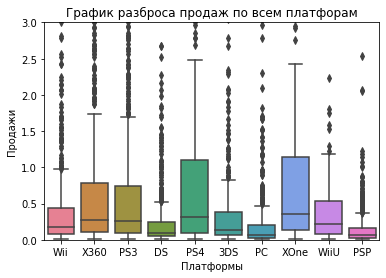

In [25]:
sns.boxplot(x='platform', y="total_sales", data=df_top10_2009, palette='husl')
plt.title('График разброса продаж по всем платфорам')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.ylim(0, 3)
plt.show();

###  Построим график «ящик с усами» по глобальным продажам 


Мы видим 4 наиболее популярных и актуальных  по продажам платформ - X360, PS3, PS4, XOne. У остальных платформ продажи либо совсем в нуле либо на минимумах.

Построим боксплот и опишем данные продаж по всем топовым платформам и потом по 2-м топовым и сравним их.

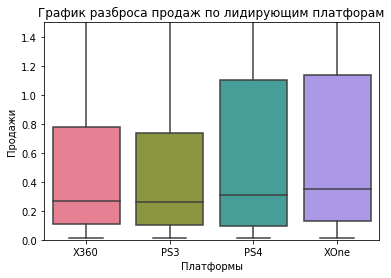

In [26]:
sns.boxplot(x='platform', y="total_sales", data=df_top10_2009[df_top10_2009['platform']
          .isin(('X360', 'PS3', 'PS4', 'XOne'))], palette='husl')
plt.title('График разброса продаж по лидирующим платфорам')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.ylim(0, 1.5)
plt.show();

Посмoтрим расределение продаж по каждой их 4 выбранных платформ

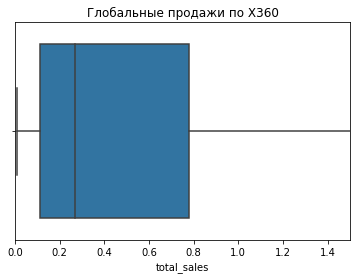

In [27]:
sns.boxplot(df_top10_2009.query('platform =="X360"')['total_sales'])
plt.title('Глобальные продажи по X360')
plt.xlim(0, 1.5)
plt.show();

In [28]:
(df_top10_2009
    .query('platform =="X360"')
    ['total_sales'].describe()
)

count   839.00
mean      0.80
std       1.75
min       0.01
25%       0.11
50%       0.27
75%       0.78
max      21.82
Name: total_sales, dtype: float64

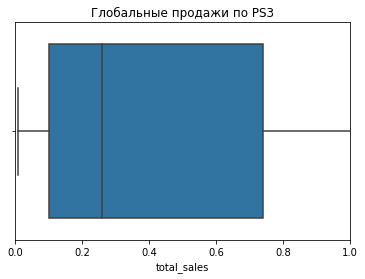

In [29]:
sns.boxplot(df_top10_2009.query('platform =="PS3"')['total_sales'])

plt.title('Глобальные продажи по PS3')
plt.xlim(0, 1)
plt.show();

In [30]:
(df_top10_2009
    .query('platform =="PS3"')
   ['total_sales'].describe()
)

count   1013.00
mean       0.71
std        1.47
min        0.01
25%        0.10
50%        0.26
75%        0.74
max       21.05
Name: total_sales, dtype: float64

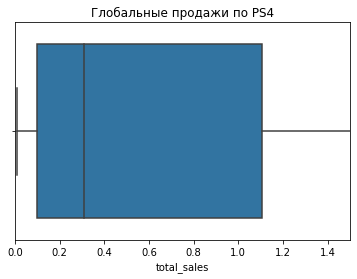

In [31]:
sns.boxplot(df_top10_2009.query('platform =="PS4"')['total_sales'])

plt.title('Глобальные продажи по PS4')
plt.xlim(0, 1.5)
plt.show();

In [32]:
(df_top10_2009
    .query('platform =="PS4"')
    ['total_sales'].describe()
)

count   228.00
mean      1.07
std       1.90
min       0.01
25%       0.10
50%       0.31
75%       1.10
max      14.63
Name: total_sales, dtype: float64

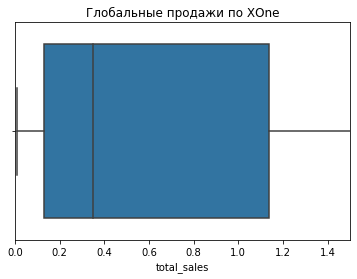

In [33]:
sns.boxplot(df_top10_2009.query('platform =="XOne"')['total_sales'])

plt.title('Глобальные продажи по XOne')
plt.xlim(0, 1.5)
plt.show()

In [34]:
(df_top10_2009
    .query('platform =="XOne"')
    ['total_sales'].describe()
)

count   160.00
mean      0.83
std       1.18
min       0.01
25%       0.13
50%       0.35
75%       1.14
max       7.39
Name: total_sales, dtype: float64

Исходя из данных мы видим средние показатели продаж по всем  платформам :\
платформа 360 mean = 0,27 , median = 0,8 , std = 1,75\
платформа PS3 mean = 0,71 , median = 0,26 , std = 1,47\
платформа PS4 mean = 1,1 , median = 0,3 , std = 1,9\
платформа XOne mean = 0,8 , median = 0,35 , std = 1,2

Наиболее популярная платформа PS4, она имеет самые высокие показатели продаж, так же это можно обосновать активным продвижением бренда PS4 во всем мире, особенно после 2009.

Посмотрим как влияют на продажи внутри одной популярной платформы, в нашем случае PS4, отзывы покупателей и критиков.


###  Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.


Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

Напишем функцию для нахождения корреляции по платформе


In [35]:
# создадим общую функцию создания таблицы корреляции и отрисовкий диаграммы рассеяния
def platform_correlation(platform, title):
    """
    Функция на вход принимает два значения для расчета:
    platform - платформа по которой будет рассчитана корреляция и диаграмма рассеяния
    title - заголовок графика
    Затем строятся два графика рассеяния - глобальных продаж по пользовательским оценкам
    и глобальные продажи по оценкам критиков. На графиках строится линия, указывающая направление корреляции.
    """
    plt.figure(figsize=(12, 5))
    sns.regplot(data=df[df.platform == platform], 
                x='total_sales', y='user_score', 
                line_kws={"color":"r","alpha":0.7,"lw":5}
               ).set(title=title, xlabel='Количество проданных копий, млн.',
                     ylabel='Пользовательская оценка');
    plt.figure(figsize=(12, 5))
    sns.regplot(data=df[df.platform == platform],
                x='total_sales', y='critic_score',
                line_kws={"color":"r","alpha":0.7,"lw":5}
               ).set(title=title, xlabel='Количество проданных копий, млн.',
                     ylabel='Оценка критиков');
    display(df[df.platform == platform][['total_sales', 'critic_score','user_score']].corr(
    ).style.background_gradient(cmap='Greens'))

Построим диграмму рассеяния продаж X360',

,total_sales,critic_score,user_score
total_sales,1,0.393736,0.114459
critic_score,0.393736,1,0.618101
user_score,0.114459,0.618101,1


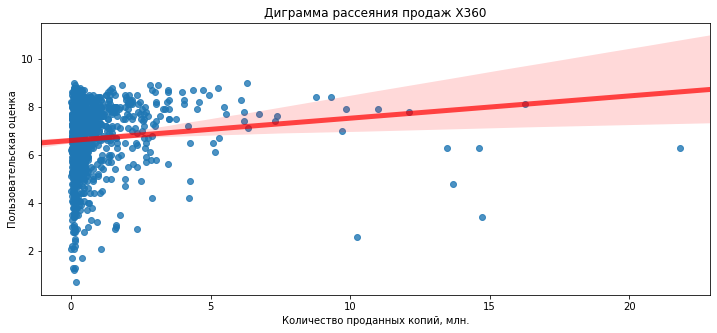

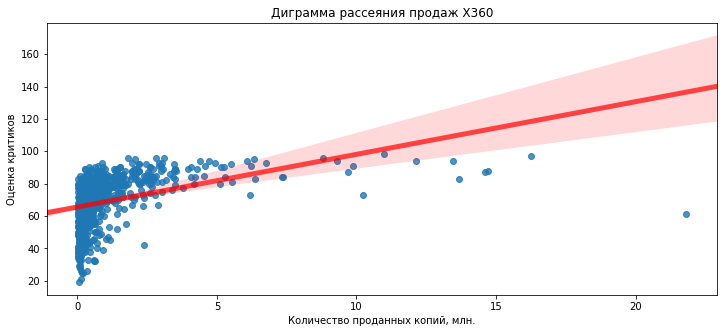

In [36]:
platform_correlation('X360','Диграмма рассеяния продаж X360')

Для платформы X360 наблюдаем положильеную корреляцию  оценки пользоватлей.

Построим диграмму рассеяния продаж  PS3

,total_sales,critic_score,user_score
total_sales,1,0.432432,0.126691
critic_score,0.432432,1,0.629005
user_score,0.126691,0.629005,1


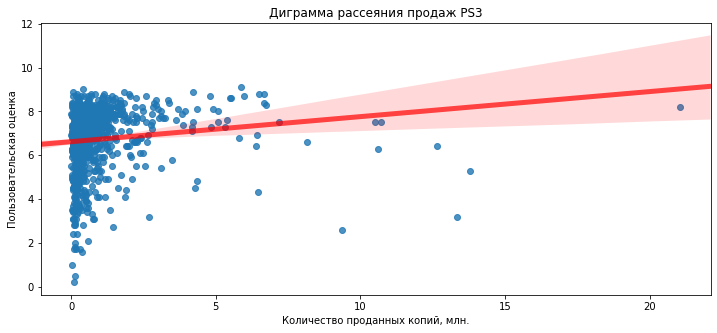

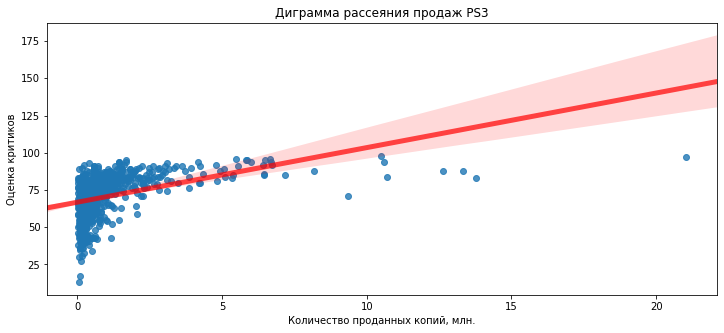

In [37]:
platform_correlation('PS3','Диграмма рассеяния продаж PS3')

Для платформы PS3 наблюдаем положильную корреляцию  оценки пользователей

Построим диграмму рассеяния продаж  PS4

,total_sales,critic_score,user_score
total_sales,1,0.406568,-0.0319571
critic_score,0.406568,1,0.557654
user_score,-0.0319571,0.557654,1


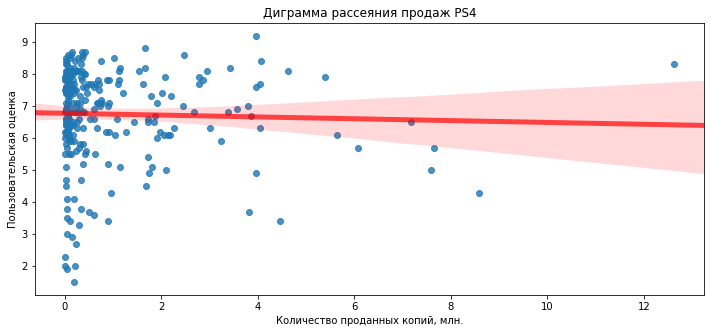

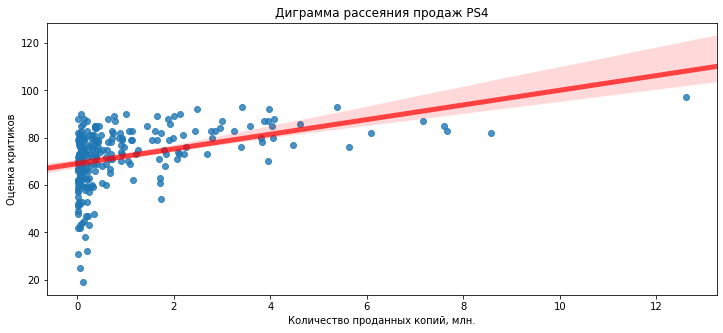

In [38]:
platform_correlation('PS4','Диграмма рассеяния продаж PS4')

Для платформы PS4 видим отрицальную корреляцию  оценок пользоватлей 

Построим диграмму рассеяния продаж   XOne

,total_sales,critic_score,user_score
total_sales,1,0.416998,-0.0689251
critic_score,0.416998,1,0.472462
user_score,-0.0689251,0.472462,1


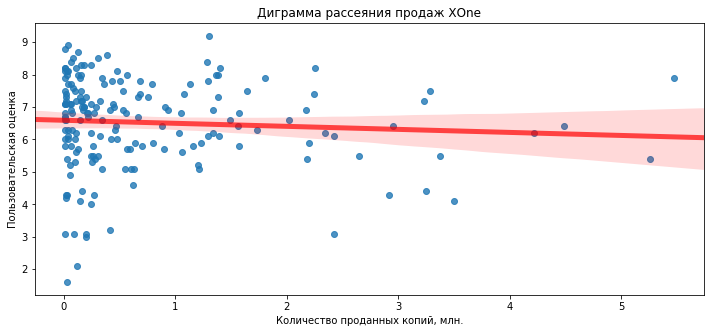

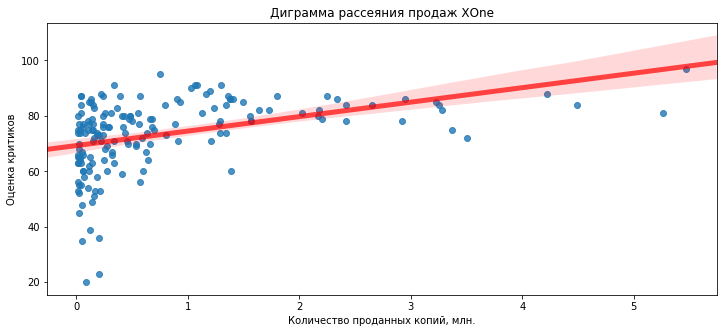

In [39]:
platform_correlation('XOne','Диграмма рассеяния продаж XOne')

Для платформы XOne наблюдаем отрицальную корреляцию  оценок пользователей 


Для  X360 и PS3 положильная  корреляция оценок пользователей.\
Для PS4 и XOne отрицальная корреляция оценок пользователей.

То есть отрицательной корреляции оценки критиков влияют на продажи игр (чем хуже критик оценит игру, тем хуже она будет продаваться)



 коэффициент корреляции с продажами:
- critic_score: 0,42
- user_score: 0,07

Значит можно сделать вывод, что оценки критиков сильнее влияют на успешность игры. По остальным платформам картина аналогичная.


###  Соотнесем выводы с продажами игр 


In [40]:
df_top10_2009.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8.00,6.00,32.77
8,New Super Mario Bros. Wii,Wii,2009.00,Platform,14.44,6.94,4.70,2.24,87.00,8.40,6.00,28.32
14,Kinect Adventures!,X360,2010.00,Misc,15.00,4.89,0.24,1.69,61.00,6.30,6.00,21.82
15,Wii Fit Plus,Wii,2009.00,Sports,9.01,8.49,2.53,1.77,80.00,7.40,6.00,21.80
16,Grand Theft Auto V,PS3,2013.00,Action,7.02,9.09,0.98,3.96,97.00,8.20,15.00,21.05


In [41]:
(df_top10_2009
    .groupby('genre')
    .agg({'total_sales':['median']})
    .sort_values(by=('total_sales', 'median'), ascending=False)
)

,total_sales
,median
genre,
Shooter,0.36
Platform,0.24
Fighting,0.23
Sports,0.21
Action,0.19
Racing,0.18
Role-Playing,0.17
Misc,0.15


###  Посмотрим на общее распределение игр по жанрам

Самые прибыльные жанры:  Shooter, Fighting\
Самые низкодоходные жанры: Adventure, Strategy\
*Вывод\
Мы видим что средний срок жизни платформы около 9 лет и актуальность данных с 2009 по 2015 год.
Исходя из данных мы видим 2-х лидеров по платформам PS4, XOne, 3DS, WiiU. Платформа PS4 на данный момент имеет самые высокие показатели продаж.\
Мы видим для PS4, XOne есть прямая корреляция с отзывами критиков и отсутствие корреляции для отзывов покупателей.\
Для 3DS, WiiU есть прямая корреляция с отзывами критиков и отзывами покупателей.\

## Портрет пользователя каждого региона

In [42]:
df_top10_2009.head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8.00,6.00,32.77
8,New Super Mario Bros. Wii,Wii,2009.00,Platform,14.44,6.94,4.70,2.24,87.00,8.40,6.00,28.32
14,Kinect Adventures!,X360,2010.00,Misc,15.00,4.89,0.24,1.69,61.00,6.30,6.00,21.82
15,Wii Fit Plus,Wii,2009.00,Sports,9.01,8.49,2.53,1.77,80.00,7.40,6.00,21.80
16,Grand Theft Auto V,PS3,2013.00,Action,7.02,9.09,0.98,3.96,97.00,8.20,15.00,21.05
23,Grand Theft Auto V,X360,2013.00,Action,9.66,5.14,0.06,1.41,97.00,8.10,15.00,16.27
27,Pokemon Black/Pokemon White,DS,2010.00,Role-Playing,5.51,3.17,5.65,0.80,nan,nan,no_data,15.13
29,Call of Duty: Modern Warfare 3,X360,2011.00,Shooter,9.04,4.24,0.13,1.32,88.00,3.40,15.00,14.73
31,Call of Duty: Black Ops 3,PS4,2015.00,Shooter,6.03,5.86,0.36,2.38,nan,nan,no_data,14.63
32,Call of Duty: Black Ops,X360,2010.00,Shooter,9.70,3.68,0.11,1.13,87.00,6.30,15.00,14.62


### вопросы для региона  Северной Америке

####  Самые популярные платформы (топ-5) в Северной Америке


In [43]:
platforms = (df_top10_2009
    .groupby('platform')
    .agg({'na_sales':['sum']})
    .sort_values(by=('na_sales', 'sum'), ascending=False)
    .copy()
)
platforms.columns = ['sum_sales']
total_sum_sales = platforms.sum()
print(total_sum_sales)
display(platforms.head(5))

sum_sales   1397.03
dtype: float64


,sum_sales
platform,
X360,407.49
PS3,291.23
Wii,235.69
DS,120.61
PS4,87.25


Видим, что в регионе Северная Америка самые популярные плаформы X360, PS3, Wii, DS, PS4

#### Доли продаж платформ в Северной Америке

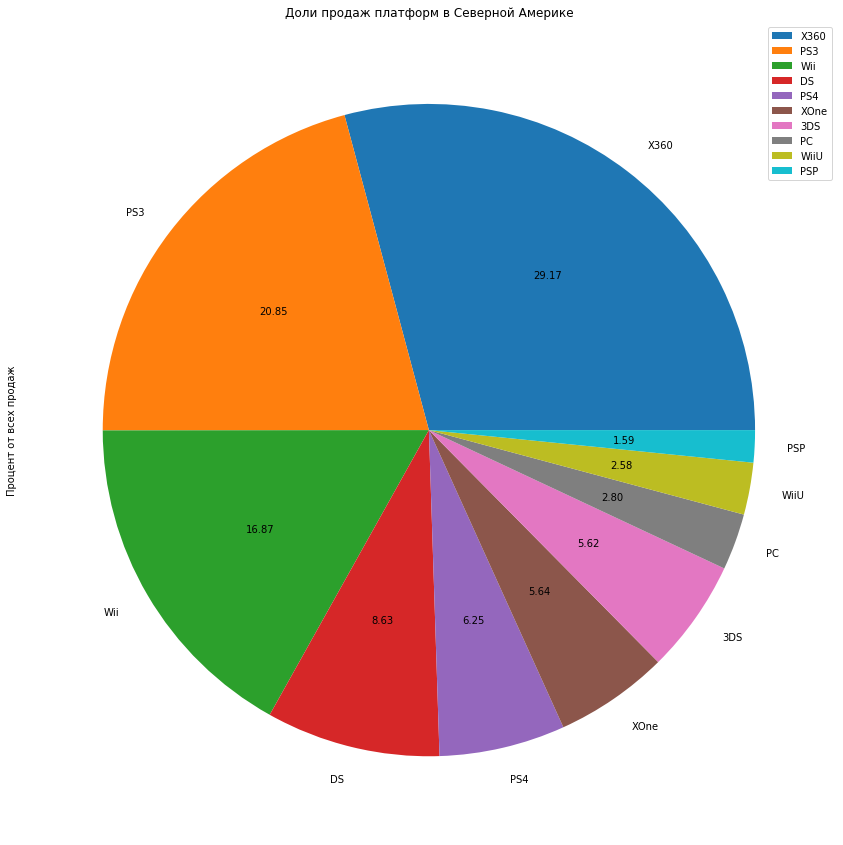

In [44]:
platforms['sales_share'] = (platforms['sum_sales'] / total_sum_sales['sum_sales'])
platforms['sales_share'].plot(kind='pie', autopct='%1.2f', figsize =(15,15),legend = True)
plt.title('Доли продаж платформ в Северной Америке')
plt.ylabel('Процент от всех продаж');

####  Самые популярные жанры (топ-5) в Северной Америке


In [45]:
genres = (df_top10_2009
    .groupby('genre')
    .agg({'na_sales':['sum']})
    .sort_values(by=('na_sales', 'sum'), ascending=False)
    .copy()
)
genres.columns = ['sum_sales']
total_sum_sales = genres.sum()
print(total_sum_sales)
display(genres.head(5))

sum_sales   1397.03
dtype: float64


,sum_sales
genre,
Action,346.16
Shooter,258.30
Sports,215.12
Misc,161.40
Role-Playing,122.64


Видим, что в регионе Северная Америка самые популярные жанры  Action, Shooter, Sports, Misc, Role-Playing	

#### Доли продаж по жанрам в Северной Америке

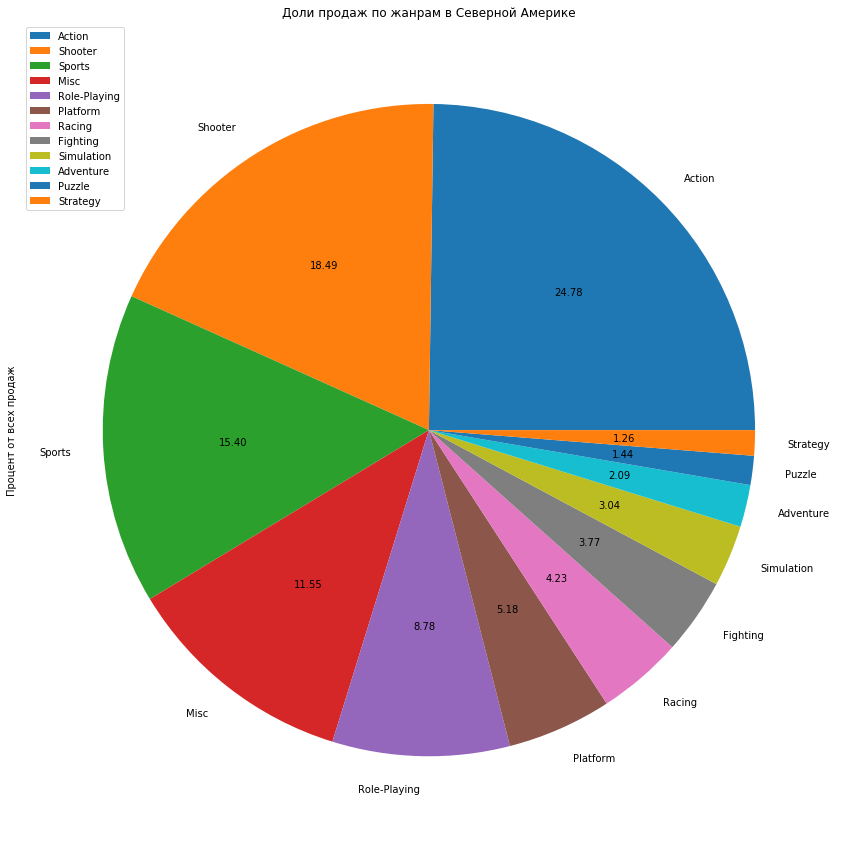

In [46]:
genres['sales_share'] = (genres['sum_sales'] / total_sum_sales['sum_sales'])
genres['sales_share'].plot(kind='pie', autopct='%1.2f', figsize =(15,15),legend = True)
plt.title('Доли продаж по жанрам в Северной Америке')
plt.ylabel('Процент от всех продаж');

####  Влияет ли рейтинг ESRB на продажи в Северной Америке


In [47]:
ratings = (df_top10_2009
    .groupby('rating')
    .agg({'na_sales':['sum']})
    .sort_values(by=('na_sales', 'sum'), ascending=False)
    .copy()
)
ratings.columns = ['sum_sales']
total_sum_sales = ratings.sum()
print(total_sum_sales)
display(ratings)

sum_sales   1397.03
dtype: float64


,sum_sales
rating,
15.0,421.32
6.0,388.59
13.0,211.96
10.0,194.53
no_data,179.31
3.0,1.32


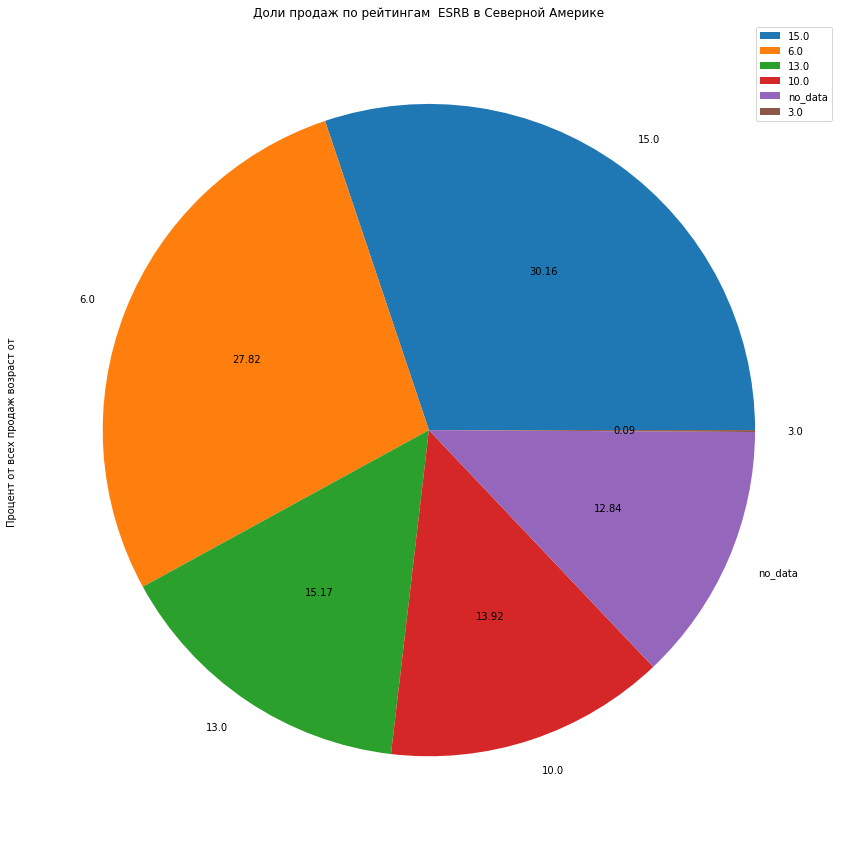

In [48]:
ratings['sales_share'] = (ratings['sum_sales'] / total_sum_sales['sum_sales'])
ratings['sales_share'].plot(kind='pie', autopct='%1.2f', figsize =(15,15),legend = True)
plt.title('Доли продаж по рейтингам  ESRB в Северной Америке')
plt.ylabel('Процент от всех продаж возраст от ');

Мы видим, что в Севернной Америке топ 5 популярных платформ X360, PS3, Wii, PS4, DS.\
Мы видим, что в Севернной Америке топ 5 популярных жанров Action, Sports, Shooter, Misc, Role-Playing.\
Также в Севернной Америке продаются игры хорошо с возрастными рейтингами ERSB 6+(28%), 15+(30%, как основной сегмент выделим 15+


### Ответим на вопросы для региона Европе

#### Самые популярные платформы (топ-5) в Европе

In [49]:
platforms = (df_top10_2009
    .groupby('platform')
    .agg({'eu_sales':['sum']})
    .sort_values(by=('eu_sales', 'sum'), ascending=False)
    .copy()
)
platforms.columns = ['sum_sales']
total_sum_sales = platforms.sum()
print(total_sum_sales)
display(platforms.head(5))

sum_sales   958.64
dtype: float64


,sum_sales
platform,
PS3,253.74
X360,196.01
Wii,124.11
PS4,109.31
PC,78.79


 Самые популярные платформы в Европе PS3, X360,  Wii, PS4, PC

####  Доли продажи платформ в Европе

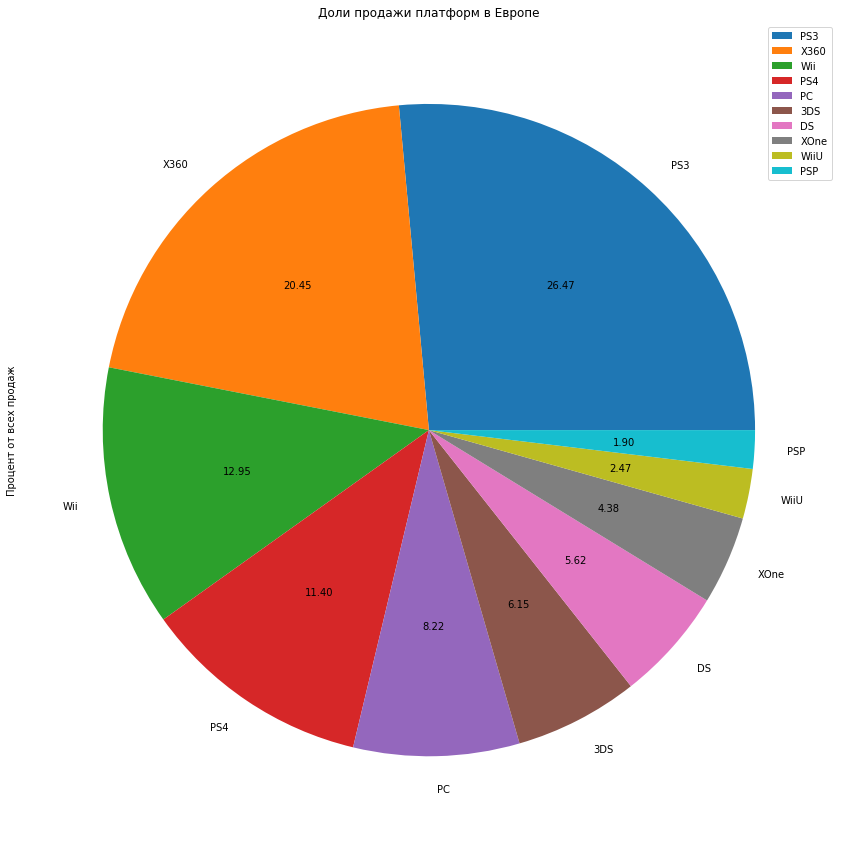

In [50]:
platforms['sales_share'] = (platforms['sum_sales'] / total_sum_sales['sum_sales'])
platforms['sales_share'].plot(kind='pie', autopct='%1.2f', figsize =(15,15),legend = True)
plt.title('Доли продажи платформ в Европе')
plt.ylabel('Процент от всех продаж');

####  Самые популярные жанры  (топ-5)  в Европе

In [51]:
genres = (df_top10_2009
    .groupby('genre')
    .agg({'eu_sales':['sum']})
    .sort_values(by=('eu_sales', 'sum'), ascending=False)
    .copy()
)
genres.columns = ['sum_sales']
total_sum_sales = genres.sum()
print(total_sum_sales)
display(genres.head(5))

sum_sales   958.64
dtype: float64


,sum_sales
genre,
Action,256.07
Shooter,174.82
Sports,142.79
Misc,83.48
Role-Playing,78.12


Самые популярные жанры в Европе Action, Shooter, Sports, Misc, Role-Playing	

#### Доли продаж по жанрам в Европе

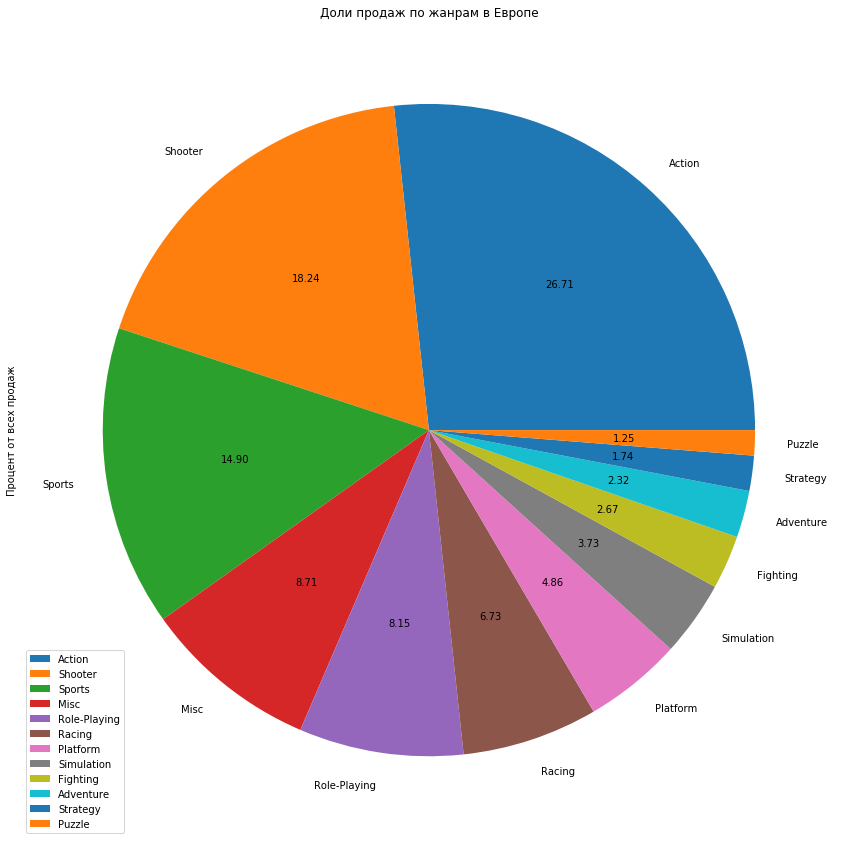

In [52]:
genres['sales_share'] = (genres['sum_sales'] / total_sum_sales['sum_sales'])
genres['sales_share'].plot(kind='pie', autopct='%1.2f', figsize =(15,15),legend = True)
plt.title('Доли продаж по жанрам в Европе')
plt.ylabel('Процент от всех продаж');

#### Влияет ли рейтинг ESRB на продажи в Европе

In [53]:
ratings = (df_top10_2009
    .groupby('rating')
    .agg({'eu_sales':['sum']})
    .sort_values(by=('eu_sales', 'sum'), ascending=False)
    .copy()
)
ratings.columns = ['sum_sales']
total_sum_sales = ratings.sum()
print(total_sum_sales)
display(ratings)

sum_sales   958.64
dtype: float64


,sum_sales
rating,
15.0,307.12
6.0,242.97
no_data,155.28
13.0,139.81
10.0,113.46
3.0,0.00


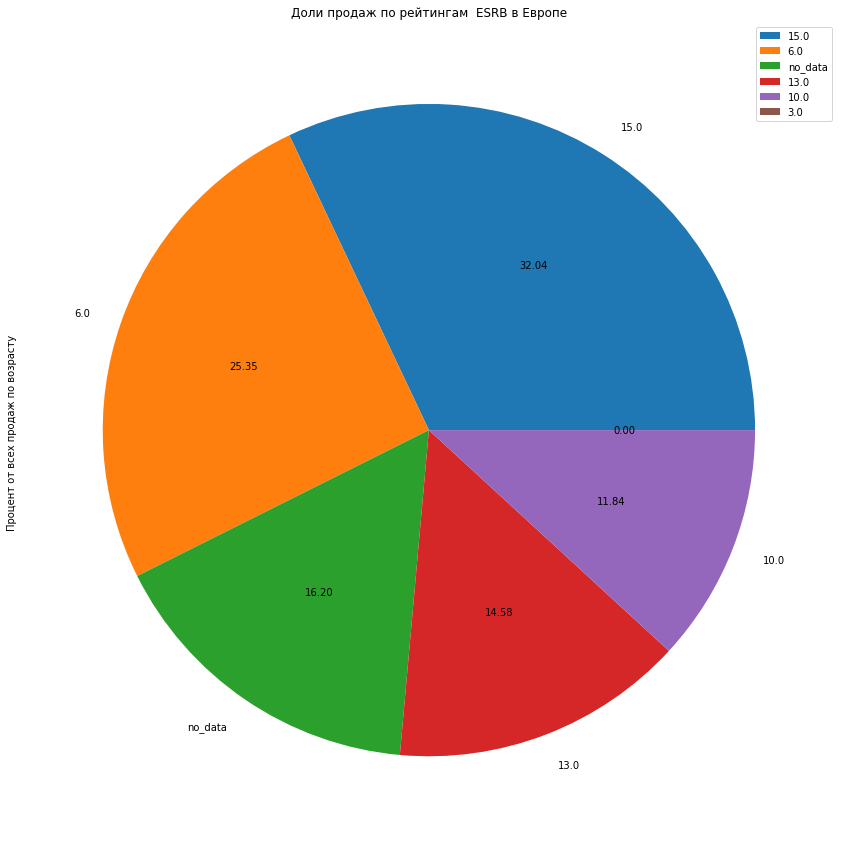

In [54]:
ratings['sales_share'] = (ratings['sum_sales'] / total_sum_sales['sum_sales'])
ratings['sales_share'].plot(kind='pie', autopct='%1.2f', figsize =(15,15),legend = True)
plt.title('Доли продаж по рейтингам  ESRB в Европе')
plt.ylabel('Процент от всех продаж по возрасту ');

Протрет пользователя в Европе:

платформа: PS3, X360, WiiU\
жанры: Action, Sports, Shooter\
Мы видим что в Европе продаються игры хорошо с возрастными рейтингами ERSB 6+(25%), 15+(32%), как основной сегмент выделим 15+

### Ответим на вопросы для региона Япония

#### Самые популярные платформы (топ-5)  в Японии

In [55]:
platforms = (df_top10_2009
    .groupby('platform')
    .agg({'jp_sales':['sum']})
    .sort_values(by=('jp_sales', 'sum'), ascending=False)
    .copy()
)
platforms.columns = ['sum_sales']
total_sum_sales = platforms.sum()
print(total_sum_sales)
display(platforms.head(5))

sum_sales   326.70
dtype: float64


,sum_sales
platform,
3DS,92.59
PS3,66.99
DS,52.11
PSP,50.39
Wii,34.32


Самые популярные платформы в Японии 3DS, PS3, DS, PSP, Wii

#### Доли продажи платформ

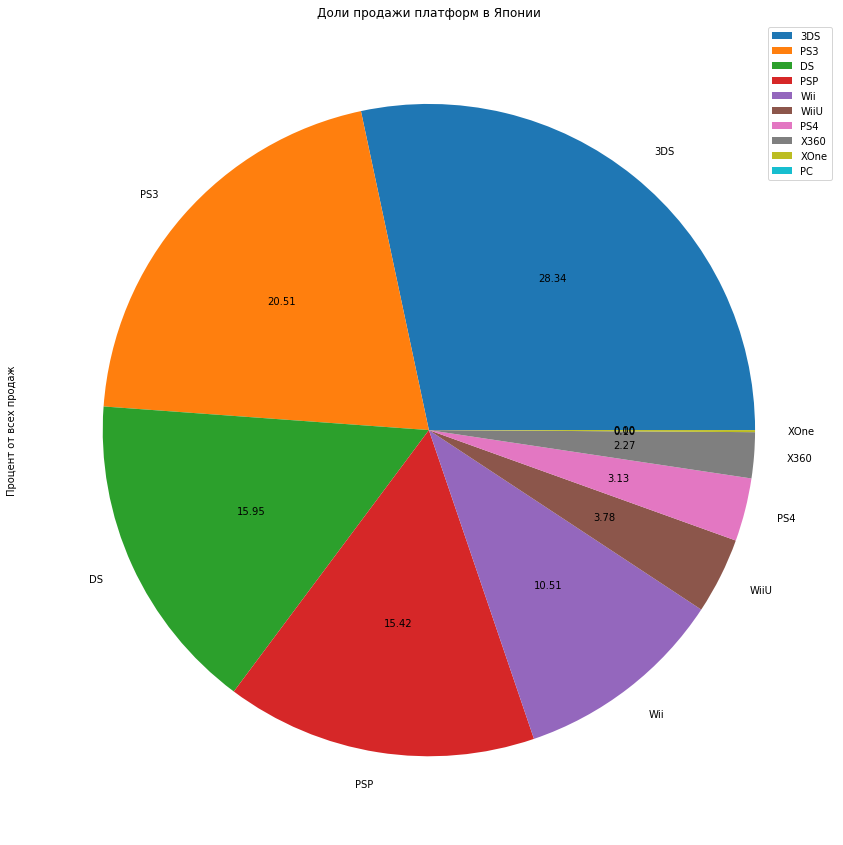

In [56]:
platforms['sales_share'] = (platforms['sum_sales'] / total_sum_sales['sum_sales'])
platforms['sales_share'].plot(kind='pie', autopct='%1.2f', figsize =(15,15),legend = True)
plt.title('Доли продажи платформ в Японии')
plt.ylabel('Процент от всех продаж');

#### Самые популярные жанры (топ-5)  в Японии

In [57]:
genres = (df_top10_2009
    .groupby('genre')
    .agg({'jp_sales':['sum']})
    .sort_values(by=('jp_sales', 'sum'), ascending=False)
    .copy()
)
genres.columns = ['sum_sales']
total_sum_sales = genres.sum()
print(total_sum_sales)
display(genres.head(5))

sum_sales   326.70
dtype: float64


,sum_sales
genre,
Role-Playing,107.15
Action,71.70
Misc,26.76
Sports,22.68
Platform,20.48


 Самые популярные жанры в Японии Role-Playing, Action, Misc, Sports, Platform

#### Доли продаж по жанрам в Японии

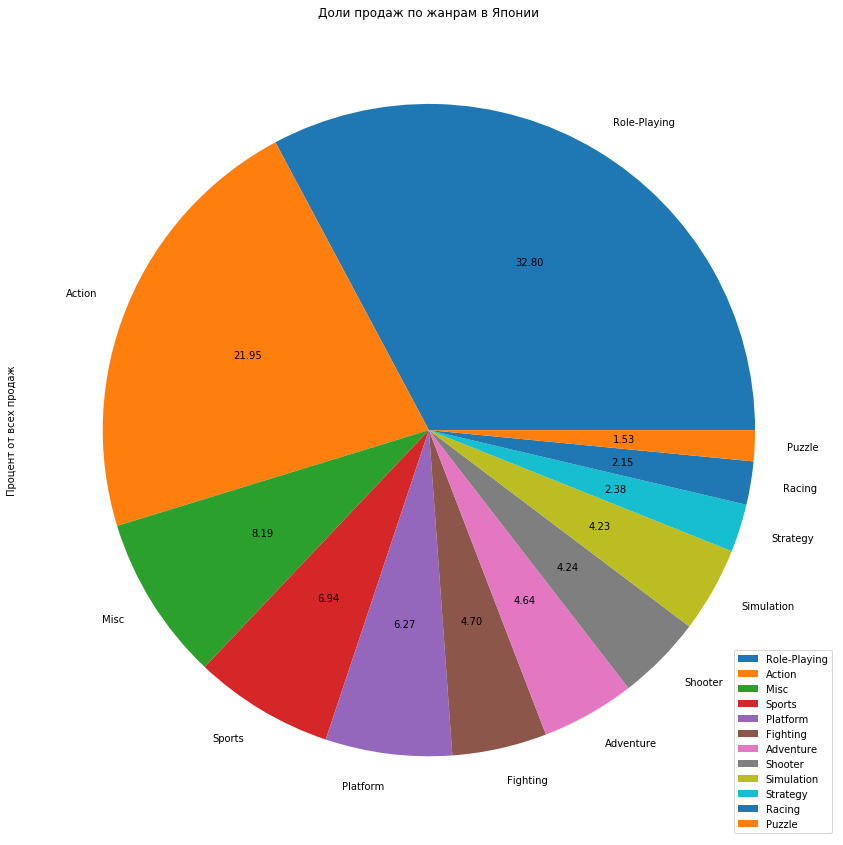

In [58]:
genres['sales_share'] = (genres['sum_sales'] / total_sum_sales['sum_sales'])
genres['sales_share'].plot(kind='pie', autopct='%1.2f', figsize =(15,15),legend = True)
plt.title('Доли продаж по жанрам в Японии')
plt.ylabel('Процент от всех продаж');

#### Влияет ли рейтинг ESRB на продажи

In [59]:
ratings = (df_top10_2009
    .groupby('rating')
    .agg({'jp_sales':['sum']})
    .sort_values(by=('jp_sales', 'sum'), ascending=False)
    .copy()
)
ratings.columns = ['sum_sales']
total_sum_sales = ratings.sum()
print(total_sum_sales)
display(ratings)

sum_sales   326.70
dtype: float64


,sum_sales
rating,
no_data,171.53
6.0,59.77
13.0,42.78
15.0,32.50
10.0,20.12
3.0,0.00


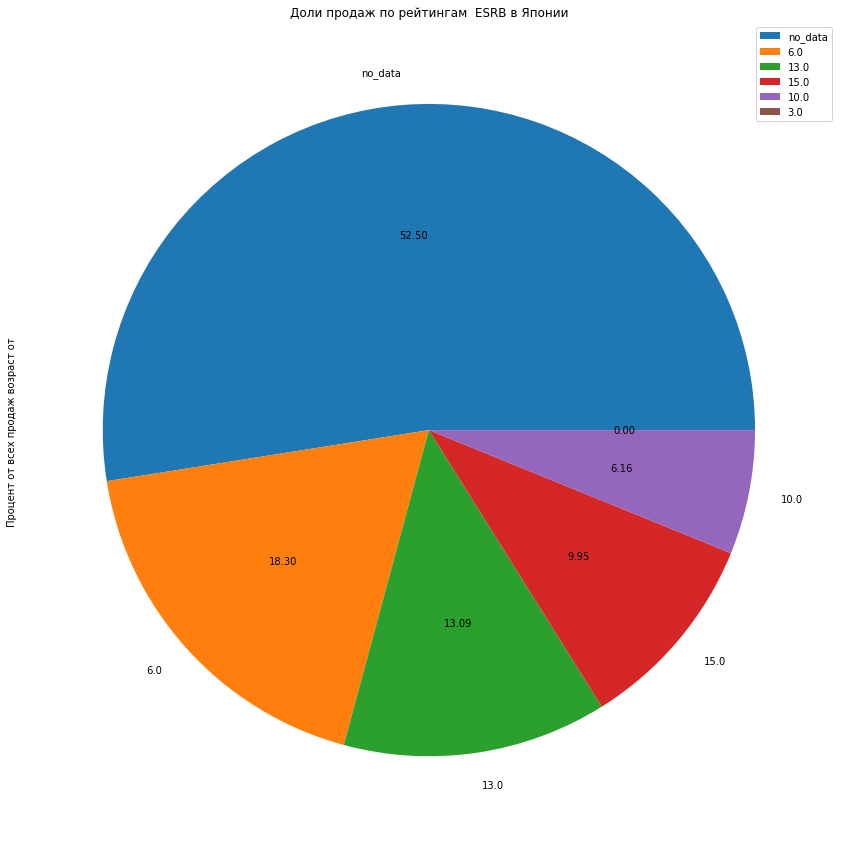

In [60]:
ratings['sales_share'] = (ratings['sum_sales'] / total_sum_sales['sum_sales'])
ratings['sales_share'].plot(kind='pie', autopct='%1.2f', figsize =(15,15),legend = True)
plt.title('Доли продаж по рейтингам  ESRB в Японии')
plt.ylabel('Процент от всех продаж возраст от ');

Протрет пользователя в Японии:

Мы видим что в Японии топ 5 популярных платформ PS3,X360, Wii\
Мы видим что в Японии топ 5 популярных жанров Role-playing, Action, Misc\
Мы видим что в Японии более половины продаж игр без рейтинга ESRB и дать корректную оценку сложно. \
По тем данным что есть мы видим, что большая доля у сегмента 6+(18%) и у сегмента 13+(13%).

Общий вывод

Мы видим, что портрет американского потребителя и европейского почти одинаковый. \
Японцы имеют аналогичный интерес по платформам, но больше предпочитают ролевый игры, думаю это связанно с большим развитием технологий и погружением страны в киберспорт. \
Возрастной рейтинг Японского пользователя по ERSB аналогичен американскому и европейскому, но более сконцентрирован на молодом и среднем возрастном сегменте от 6 и от 13 лет. Возможно это связанно со сменой приоритетов после 15 лет и потребитель начинают вместо игр делать акцент больше на саморазвитии и карьере после 15 лет. \
А в Европе и Северной Америке типовой потребитель очень долго ищет себя в жизни и в это время отдыхает , развлекаеться вплоть до 30 лет. \
Так же по данным в Японии большая доля пропусков, возможно это связанно со спецификой рынка, который делает акцент на очень широкий круг не популярных игр, которые не имеюют международного рейтинга или спроса в других странах.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые


Проверим гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые c альфа = 5%. Сформируем сначала нулевую гипотезу для равенства двух генеральных совокупностей и если она не опровергнется, дальше попробуем опровергнуть альтернативную гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC разные.

In [61]:
stat_xboxone= df_top10_2009.query('platform == "XOne" and user_score != "NaN"')['user_score'].reset_index(drop=True).copy()
stat_pc = df_top10_2009.query('platform == "PC" and user_score != "NaN"')['user_score'].reset_index(drop=True).copy()

mean_xboxone = stat_xboxone.mean()
mean_pc = stat_pc.mean()

Посмотрим и сравним дисперсию двух выборок, если она отличаеться более чем на 10% тогда в Т-тесте зададим параметр, equal_var = False(по умолчанию True) и дисперсия будет оценена для каждый выборки по отдельности, а не общей.


In [62]:

print(stat_xboxone.var())
print(stat_pc.var())

1.6594932533733138
2.3347565728864006


Мы видим что диспеерсии выборок отличается более чем на 10%, берем аргумент equal_var=False в Т-тест

Проверим следующие гипотезы:\
Н0 - средние пользовательские рейтинги платформ Xbox One и PC равны\
Н1 - средние пользовательские рейтинги платформ Xbox One и PC разные

In [63]:
alpha = .05 

results = st.ttest_ind(
    stat_xboxone, 
    stat_pc, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    if mean_xboxone != mean_pc:
        print('Средние пользовательские рейтинги платформ Xbox One и PC могут отличатся','так как Xbox One', mean_xboxone,'не равно PC',mean_pc)

p-значение: 0.1328944413299349
Не получилось отвергнуть нулевую гипотезу
Средние пользовательские рейтинги платформ Xbox One и PC могут отличатся так как Xbox One 6.477586206896552 не равно PC 6.690776699029126


У нас не получилось опровергнуть нулевую гипотезу о равнстве генеральных совокупностей с альфа= 5%, соответственно по альтернативной гипотезе средние пользовательские рейтинги могут отличатся, опровергнуть ее у нас не получилось. Полученное значение p-value говорит о том, что хотя средний пользовательский рейтинг и неодинаков, с вероятностью 13% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними пользовательскими рейтингами, но мы можем допустить такой вариант, так как он не опровергнут.

У нас получилось опровергнуть нулевую гипотезу о равнстве генеральных совокупностей с альфа= 5%, соответственно делать какие либо выводы по данным от разных платформ мы не можем.


### Средние пользовательские рейтинги жанров Action  и Sports - разные



Проверим гипотезу, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования»)  разные c альфа = 5%. Сформируем сначала нулевую гипотезу для равенства двух генеральных совокупностей и если она не опровергнется, дальше попробуем опровергнуть альтернативную гипотезу, что средние пользовательские рейтинги жанров Action и Sports разные.

In [64]:
stat_Action= df_top10_2009.query('genre == "Action" and user_score != "NaN"')['user_score'].reset_index(drop=True).copy()
stat_Sports = df_top10_2009.query('genre == "Sports" and user_score != "NaN"')['user_score'].reset_index(drop=True).copy()

mean_Action = stat_Action.mean()
mean_Sports = stat_Sports.mean()

Посмотрим и сравним дисперсию двух выборок, если она отличаеться более чем на 10% тогда в Т-тесте зададим параметр, equal_var = False(по умолчанию True) и дисперсия будет оценена для каждый выборки по отдельности, а не общей.

In [65]:
print(stat_Action.var())
print(stat_Sports.var())

1.7615935554393802
2.668756924079505


Мы видим что диспеерсии выборок отличается более чем на 10%, берем аргумент equal_var=False в Т-тесте.

Проверим следующие гипотезы: \
Н0 - средние пользовательские рейтинги жанров Action  и Sports  равны\
Н1 - средние пользовательские рейтинги жанров Action  и Sports  разные

In [66]:
alpha = .05 

results = st.ttest_ind(
    stat_Action, 
    stat_Sports, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    if mean_Action != mean_Sports:
        print('Средние пользовательские рейтинги жанров Action и Sports могут отличатся',mean_Action,'!=',mean_Sports)

p-значение: 8.65472911538364e-12
Отвергаем нулевую гипотезу


У нас получилось опровергнуть нулевую гипотезу о равнстве генеральных совокупностей с альфа= 5%, соответственно делать какие либо выводы по данным от разных жанров мы не можем.

Вывод

Мы проверили гипотезы:
1) Средние пользовательские рейтинги платформ Xbox One и PC разные. У нас не получилось опровергнуть нулевую гипотезу о равнстве генеральных совокупностей с альфа= 5%, соответственно по альтернативной гипотезе средние пользовательские рейтинги могут отличатся.\
2) Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные. У нас получилось опровергнуть нулевую гипотезу о равнстве генеральных совокупностей с альфа= 5%, соответственно делать какие либо выводы по данным от разных жанров мы не можем.

## Общий вывод

Мы видим что средний срок жизни платформы около 10 лет и актуальность данных с 2000 по 2015 год.
Исходя из данных мы видим 2-х лидеров по платформам PS4 и 3DS. Платформа PS4 на данный момент имеет стат показатели примерно в 2 раза лучше, чем 3DS у которой они на уровне средних за последние 15 лет.
Мы видим полное отсутствие корреляции между отзывами пользователей и продажами для топовой платформы, и прямую корреляцию между отзывами критиков и объемами продаж игр. Схожая ситуация и по других менее популярных платформ.
Самые прибыльный жанр - Shoote и Fighting, а самый низкодоходные Strategy и Adventure.

**Составили портреты пользователей:**

*в Северной Америке:*

платформа: X360, PS3, Wii.\
жанры Action, Shooter, Sports\
Мы видим что в Севернной Америке продаються игры хорошо с возрастными рейтингами ERSB 6+ лет, яркого преобладания какого либо сегмента не выделяется.

*в Европе:*

платформа: PS3, X360, WiiU, PS4\
жанры: Action, Sports, Shooter\
Мы видим что в Европе продаються игры хорошо с возрастными рейтингами ERSB 6+ лет , яркого преобладания какого либо сегмента не выделяется.

*в Японии:*

Мы видим что в Японии топ 5 популярных платформ PS3,X360, Wii
Мы видим что в Японии топ 5 популярных жанров Role-playing, Action, Misc
Мы видим что в Японии более половины продаж игр без рейтинга ESRB и дать корректную оценку сложно. По тем данным что есть видно, что большая доля у сегмента 6+(18%) и у сегмента 13+(13%).

Мы видим, что портрет американского потребителя и европейского почти одинаковый. Японцы имеют аналогичный интерес по платформам, но больше предпочитают ролевый игры, думаю это связанно с большим развитием технологий и погружением страны в киберспорт. Возрастной рейтинг Японского пользователя по ERSB аналогичен американскому и европейскому, но более сконцентрирован на молодом и среднем возрастном сегменте от 6 и от 13 лет. Возможно это связанно со сменой приоритетов после 15 лет и потребитель начинают вместо игр делать акцент больше на саморазвитии и карьере после 15 лет. А в Европе и Северной Америке типовой потребитель очень долго ищет себя в жизни и в это время отдыхает , развлекаеться вплоть до 30 лет. Так же по данным в Японии большая доля пропусков, возможно это связанно со спецификой рынка, который делает акцент на очень широкий круг не популярных игр, которые не имеюют международного рейтинга или спроса в других странах.

Мы проверили гипотезы:

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. У нас не получилось опровергнуть нулевую гипотезу о равнстве генеральных совокупностей с альфа= 5%, соответственно по альтернативной гипотезе средние пользовательские рейтинги могут отличатся, опровергнуть ее у нас не получилось.
Средние пользовательские рейтинги жанров Action и Sports  разные. У нас получилось опровергнуть нулевую гипотезу о равнстве генеральных совокупностей с альфа= 5%, соответственно делать какие либо выводы по данным от разных жанров мы не можем.

**Такми образом компании более выгодно акцентировать продажи на Северную Америку и Европу\
по платформам: X360, PS3, PS4\
по жанрам: Action, Sports, Shooter\
по рейтингу ESRB от 10+ лет\
Так как продукт удовлетворяющий этим критериям охватит наибольшую аудиторию и получит большой спрос.**